In [1]:
import gymnasium as gym
import pathfinders
from agents.QWL import QWLAgent
from agents.agent import SarsaAgent,QAgent
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import imageio



def moving_average(x, window_size, axis=-1):
    """
    Compute the moving average of a 2D array over a specified axis.

    Parameters:
    x (numpy.ndarray): Input array.
    window_size (int): The size of the moving average window.
    axis (int): The axis along which to compute the moving average.

    Returns:
    numpy.ndarray: The array of moving averages.
    """
    if x.ndim != 2:
        return np.convolve(x, np.ones(window_size), 'valid') / window_size
    
    # Create sliding windows
    shape = list(x.shape)
    shape[axis] -= window_size - 1
    if shape[axis] < 1:
        raise ValueError("window_size is too large for the specified axis.")
    
    # Generate the sliding window view
    x_strided = np.lib.stride_tricks.sliding_window_view(x, window_shape=window_size, axis=axis)
    
    # Compute the mean across the windows
    moving_avgs = x_strided.mean(axis=-1)

    return moving_avgs



Iteration 0
Agent QWL:
episode 100: trajectory length 320.00 - average 702.28 
episode 200: trajectory length 198.00 - average 503.36 
episode 300: trajectory length 104.00 - average 411.73 
episode 400: trajectory length 157.00 - average 352.41 
episode 500: trajectory length 134.00 - average 313.80 
episode 600: trajectory length 117.00 - average 284.59 
episode 700: trajectory length 121.00 - average 262.02 
episode 800: trajectory length 114.00 - average 244.58 
episode 900: trajectory length 98.00 - average 230.11 
episode 1000: trajectory length 116.00 - average 218.69 
episode 1100: trajectory length 125.00 - average 209.08 
episode 1200: trajectory length 261.00 - average 200.89 
episode 1300: trajectory length 86.00 - average 193.73 
episode 1400: trajectory length 100.00 - average 187.50 
episode 1500: trajectory length 93.00 - average 182.08 
episode 1600: trajectory length 104.00 - average 177.54 
episode 1700: trajectory length 129.00 - average 173.50 
episode 1800: traje

c:\Users\mb-92\anaconda3\envs\RLgym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.open_shortcut to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.open_shortcut` for environment variables or `env.get_wrapper_attr('open_shortcut')` that will search the reminding wrappers.
  logger.warn(


episode 3400: trajectory length 106.00 - average 142.69 
episode 3500: trajectory length 73.00 - average 141.73 
(15, 18) (15, 18)
episode 3600: trajectory length 141.00 - average 140.77 
episode 3700: trajectory length 141.00 - average 139.83 
episode 3800: trajectory length 98.00 - average 137.93 
episode 3900: trajectory length 54.00 - average 135.25 
episode 4000: trajectory length 21.00 - average 132.73 
episode 4100: trajectory length 27.00 - average 130.13 
episode 4200: trajectory length 20.00 - average 127.62 
(15, 18) (15, 18)
episode 4300: trajectory length 18.00 - average 125.19 
episode 4400: trajectory length 29.00 - average 122.87 
episode 4500: trajectory length 22.00 - average 120.62 
episode 4600: trajectory length 25.00 - average 118.54 
episode 4700: trajectory length 37.00 - average 116.53 
episode 4800: trajectory length 22.00 - average 114.57 
episode 4900: trajectory length 19.00 - average 112.74 
episode 5000: trajectory length 78.00 - average 110.93 
(15, 18) 

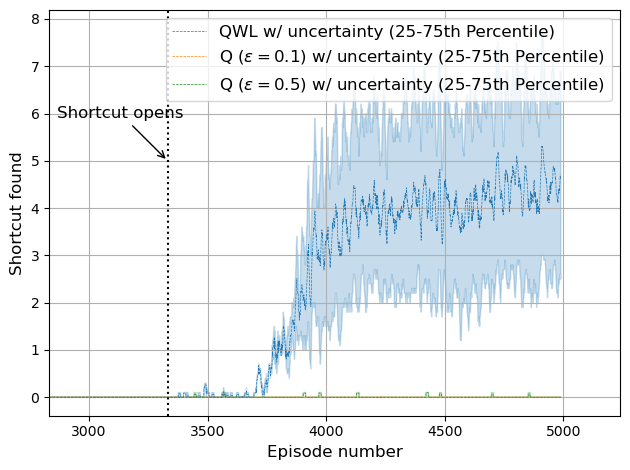

In [2]:
agents = {"QWL": QWLAgent(15,18, 4, 0.1 ,0.2,1,1000),
          r"Q ($\epsilon = 0.1$)": QAgent(15,18, 4,0.1, 0.2, 1),
          r"Q ($\epsilon = 0.5$)": QAgent(15,18, 4,0.5, 0.2, 1)
           }

np.random.seed(0)
n_episodes = 5000
evaluate_policy_after = n_episodes
evaluate_policy_every = 5
experiment_repeats = 10


eps_checks = [3332, 3500,4250,5000]

returns = {agent_name : np.zeros((len(eps_checks),experiment_repeats))  for agent_name in agents.keys()}


Q_avgs =  {agent_name : {eps_number : np.zeros((15,18)) for eps_number in eps_checks} for agent_name in agents.keys()}


shortcut_found = {agent_name : np.zeros((n_episodes,experiment_repeats)) for agent_name in agents.keys()}


optimal_lenght_shorcut_closed = 30

open_shorcut_factor = 1.5

for i in range(experiment_repeats):
    print(f"\nIteration {i}")
    for agent_name, agent in agents.items():
        agent.reset()
        print(f"Agent {agent_name}:")
        # Create the environment
        env = gym.make('shortcutshortmaze-v0', render_mode = "rgb_array")

        visited = np.zeros((15,20))
        visite_open = np.zeros((15,20))

        avg_steps = 0
        check_id = 0
       
        for episode in range(n_episodes):
       
            trajectory = []
            done = False
            observation,info= env.reset()
      
            if (episode+1) >= n_episodes//open_shorcut_factor:
                env.open_shortcut() 
            while not done:
                state = tuple(observation["agent"]["pos"])
                if (episode+1) >= n_episodes//open_shorcut_factor:
                    visite_open[state]+=1
                else: 
                    visited[state]+=1
                #action = agent.select_action(state)
                action = agent.select_behaviour_action(state)

                observation, reward, done,_, info = env.step(action)
                if done:
                    avg_steps+=info["steps"]
                next_state = tuple(observation["agent"]["pos"])
                agent.learn(state,action,reward,next_state)
                trajectory.append( (state,action,reward,next_state))
                state = next_state

            shortcut_found[agent_name][episode,i] = info["steps"]<optimal_lenght_shorcut_closed
            
            if (episode+1) %100 ==0:
                print(f"episode {episode+1}: trajectory length {info["steps"]:.2f} - average {avg_steps/(episode+1):.2f} ")

            if (episode+1) in eps_checks:
                Q = np.copy(agent.Q)
                Q_avg = Q.mean(axis=-1)
                print(Q_avg.shape,Q_avgs[agent_name][episode+1].shape )
                Q_avgs[agent_name][episode+1]+= Q_avg
                
                G = 0
                
                done = False
                observation,info= env.reset()
                
                
                while not done:
                    state = tuple(observation["agent"]["pos"])
                    action = agent.select_action(state)
                    observation, reward, done,_, info = env.step(action)
                    G +=reward
                    
                    next_state = tuple(observation["agent"]["pos"])
                    state = next_state
                returns[agent_name][check_id,i]=G
                check_id+=1

        
    
 

colors = {"QWL": "#1f77b4", r"Q ($\epsilon = 0.1$)": "#ff7f0e", r"Q ($\epsilon = 0.5$)": "#228B22"}
average_window_size = 50
x_pos = int(-1 + n_episodes // open_shorcut_factor)


cmap = plt.cm.viridis 
cmap.set_bad(color='black')

# fig, axs = plt.subplots(nrows=2,ncols=len(eps_checks),figsize=(16, 8))
# for row,(agent_name, value_funcs) in enumerate(Q_avgs.items()):
#     fig.text(0.025,(2 * (1-row) +1) / 4, agent_name, ha='center', va='center', fontsize=16)
#     for col,(eps_num, Q_avg) in enumerate(value_funcs.items()):
#         if row ==0:
#             fig.text((2 * col +1) / (2*4), 0.95, f"Episode {eps_num}", ha='center', va='center', fontsize=14)
#         Q_avg/=experiment_repeats
#         mask = Q_avg == 0
#         Q_avg[mask] = np.inf
#         masked_Q_avg = np.ma.masked_invalid(Q_avg)
#         img =axs[row,col].imshow(masked_Q_avg,cmap = cmap)
#         #axs[row,col].set_title(f"Episode {eps_num}", fontsize = 12)
#         axs[row,col].axis("off")
#         fig.colorbar(img, ax=axs[row,col], orientation='vertical')
# plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
# plt.savefig(f"plots/shortcut_short_average_Q_values_over_actions.png")
# plt.close()
# #plt.show()



for agent_name in agents.keys():



    
    print(agent_name)
     
    # cumsum = np.cumsum(shortcut_found[agent_name], axis=0)
    # mean_ma = np.mean(cumsum, axis=1)
    # std_ma = np.std(cumsum, axis=1)
    
    cumsums = np.cumsum(shortcut_found[agent_name], axis=1)
    cumsums = moving_average(cumsums,10, axis=0)
    sorted_cumsums = np.sort(cumsums, axis=1)
    median_cumsum = np.mean(sorted_cumsums,axis=1)# sorted_cumsums[:,int(experiment_repeats*0.5)]
    q25_cumsum = sorted_cumsums[:,int(experiment_repeats*0.25)]
    q75_cumsum = sorted_cumsums[:,int(experiment_repeats*0.75)]
    # avg_shortcut_found = np.mean(shortcut_found[agent_name], axis=1)
    # #std_shortcut_found = np.std(shortcut_found[agent_name], axis=1)
    # q25_shortcut_found = np.percentile(shortcut_found[agent_name],q = 25, axis=1)
    # q75_shortcut_found = np.percentile(shortcut_found[agent_name],q = 75, axis=1)
    # mean_ma = moving_average(avg_shortcut_found, average_window_size)
    # #std_ma = moving_average(std_shortcut_found, average_window_size)
    # q25_ma = moving_average(q25_shortcut_found, average_window_size)
    # q75_ma = moving_average(q75_shortcut_found, average_window_size)
    
    x = np.arange(len(median_cumsum))

    plt.plot(x , median_cumsum,'--',linewidth = 0.5,color = colors[agent_name], label = f"{agent_name} w/ uncertainty (25-75th Percentile)" )
    plt.fill_between(x, q25_cumsum , q75_cumsum, color=colors[agent_name], alpha=0.25)


plt.axvline(x = -1 + n_episodes//open_shorcut_factor, color = 'black', linestyle = ":")
# Annotate the vertical line
plt.annotate('Shortcut opens', xy=(x_pos, 5), xytext=(x_pos-200, 6),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', va='center', fontsize=12)

plt.xlim(left = x_pos-500 )
plt.ylabel("Shortcut found", fontsize=12)
plt.xlabel("Episode number", fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
#plt.savefig(f"plots/shortcut_found_short_plots.png")
plt.show()



In [22]:
returns["QWL"]

array([[-41., -41., -41., -41., -41., -41., -41., -41., -41., -41.],
       [-41., -41., -41., -41., -41., -41., -41., -41., -41., -41.],
       [-13., -13., -13., -13., -13., -13., -13., -13., -13., -13.],
       [-13., -13., -13., -13., -13., -13., -13., -13., -13., -13.]])

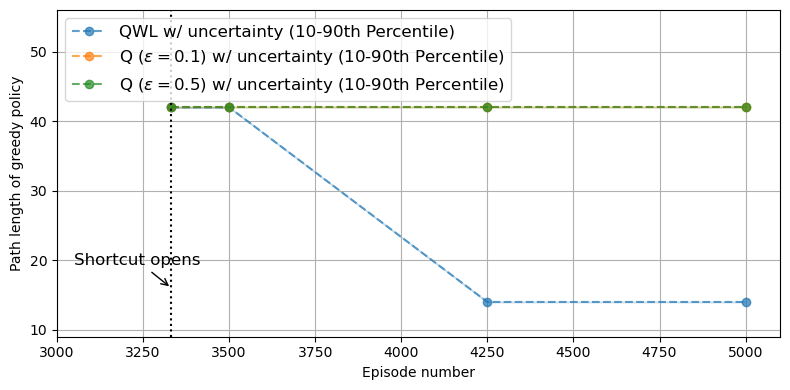

In [24]:
fig, ax = plt.subplots(figsize= (8,4))
for agent_name in agents.keys(): 
    sorted_G= np.sort(returns[agent_name], axis=1)
    G = sorted_G.mean(axis=1)
    G_25 = sorted_G[:,int(experiment_repeats*0.10)]
    G_75 = sorted_G[:,int(experiment_repeats*0.90)]
    ax.plot(eps_checks, abs(G)+1,"--o",alpha = 0.7, label = f"{agent_name} w/ uncertainty (10-90th Percentile)", color=colors[agent_name] )
    ax.fill_between(eps_checks, abs(G_25)+1 , abs(G_75)+1, color=colors[agent_name], alpha=0.25,)

ax.set_xlabel("Episode number")    
ax.set_ylabel("Path length of greedy policy")  
ax.set_xlim((3000,5100))
ax.set_ylim((9,56))
ax.axvline(x = -1 + n_episodes//open_shorcut_factor, color = 'black', linestyle = ":")
# Annotate the vertical line
ax.annotate('Shortcut opens', xy=(x_pos, 16), xytext=(x_pos-100, 20),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', va='center', fontsize=12)
plt.legend(fontsize=12,loc = "upper left")
plt.grid()
plt.tight_layout()
#plt.savefig(f"plots/shortcut_found_short_plots.png")
plt.show()
    

In [4]:
agent = agents["QWL"]
agent.epsilon = 0.05
done = False
observation,info= env.reset()
greedy_trajectory=[]
while not done:
    state = tuple(observation["agent"]["pos"])
    if (episode+1) >= n_episodes//open_shorcut_factor:
        visite_open[state]+=1
    else: 
        visited[state]+=1
    #action = agent.select_action(state)
    action = agent.select_action(state)

    observation, reward, done,_, info = env.step(action)
    if done:
        avg_steps+=info["steps"]
    next_state = tuple(observation["agent"]["pos"])
    greedy_trajectory.append(next_state)
    state = next_state
print(len(greedy_trajectory))

14


QWL
Q ($\epsilon = 0.1$)
Q ($\epsilon = 0.5$)


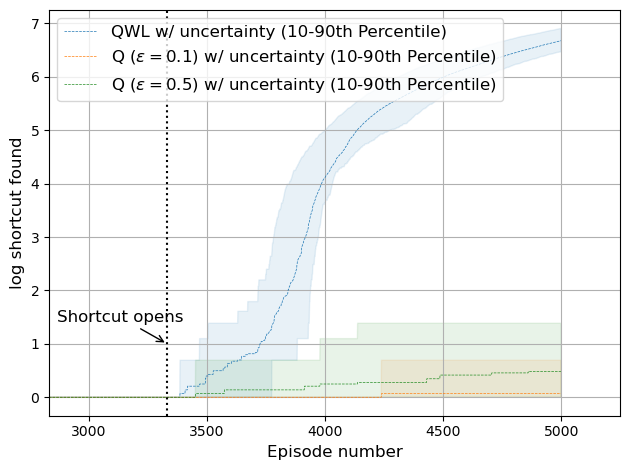

In [19]:
colors = {"QWL": "#1f77b4", r"Q ($\epsilon = 0.1$)": "#ff7f0e", r"Q ($\epsilon = 0.5$)": "#228B22"}
for agent_name in agents.keys():

    print(agent_name)
     
    # cumsum = np.cumsum(shortcut_found[agent_name], axis=0)
    # mean_ma = np.mean(cumsum, axis=1)
    # std_ma = np.std(cumsum, axis=1)
    
    cumsums = np.log(np.cumsum(shortcut_found[agent_name], axis=0)+1)
    #cumsums = moving_average(cumsums,1000, axis=0)
    sorted_cumsums = np.sort(cumsums, axis=1)
    mean_cumsum = np.mean(sorted_cumsums,axis=1)# sorted_cumsums[:,int(experiment_repeats*0.5)]
    q25_cumsum = sorted_cumsums[:,int(experiment_repeats*0.1)]
    q75_cumsum = sorted_cumsums[:,int(experiment_repeats*0.9)]
    # avg_shortcut_found = np.mean(shortcut_found[agent_name], axis=1)
    # #std_shortcut_found = np.std(shortcut_found[agent_name], axis=1)
    # q25_shortcut_found = np.percentile(shortcut_found[agent_name],q = 25, axis=1)
    # q75_shortcut_found = np.percentile(shortcut_found[agent_name],q = 75, axis=1)
    # mean_ma = moving_average(avg_shortcut_found, average_window_size)
    # #std_ma = moving_average(std_shortcut_found, average_window_size)
    # q25_ma = moving_average(q25_shortcut_found, average_window_size)
    # q75_ma = moving_average(q75_shortcut_found, average_window_size)
    
    x = np.arange(len(median_cumsum))

    plt.plot(x , mean_cumsum,'--',linewidth = 0.5,color = colors[agent_name], label = f"{agent_name} w/ uncertainty (10-90th Percentile)" )
    plt.fill_between(x, q25_cumsum , q75_cumsum, color=colors[agent_name], alpha=0.1)


plt.axvline(x = -1 + n_episodes//open_shorcut_factor, color = 'black', linestyle = ":")
# Annotate the vertical line
plt.annotate('Shortcut opens', xy=(x_pos, 1), xytext=(x_pos-200, 1.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', va='center', fontsize=12)

plt.xlim(left = x_pos-500 )
plt.ylabel("log shortcut found", fontsize=12)
plt.xlabel("Episode number", fontsize=12)
plt.legend(fontsize=12,loc = "upper left")
plt.grid()
plt.tight_layout()
#plt.savefig(f"plots/shortcut_found_short_plots.png")
plt.show()

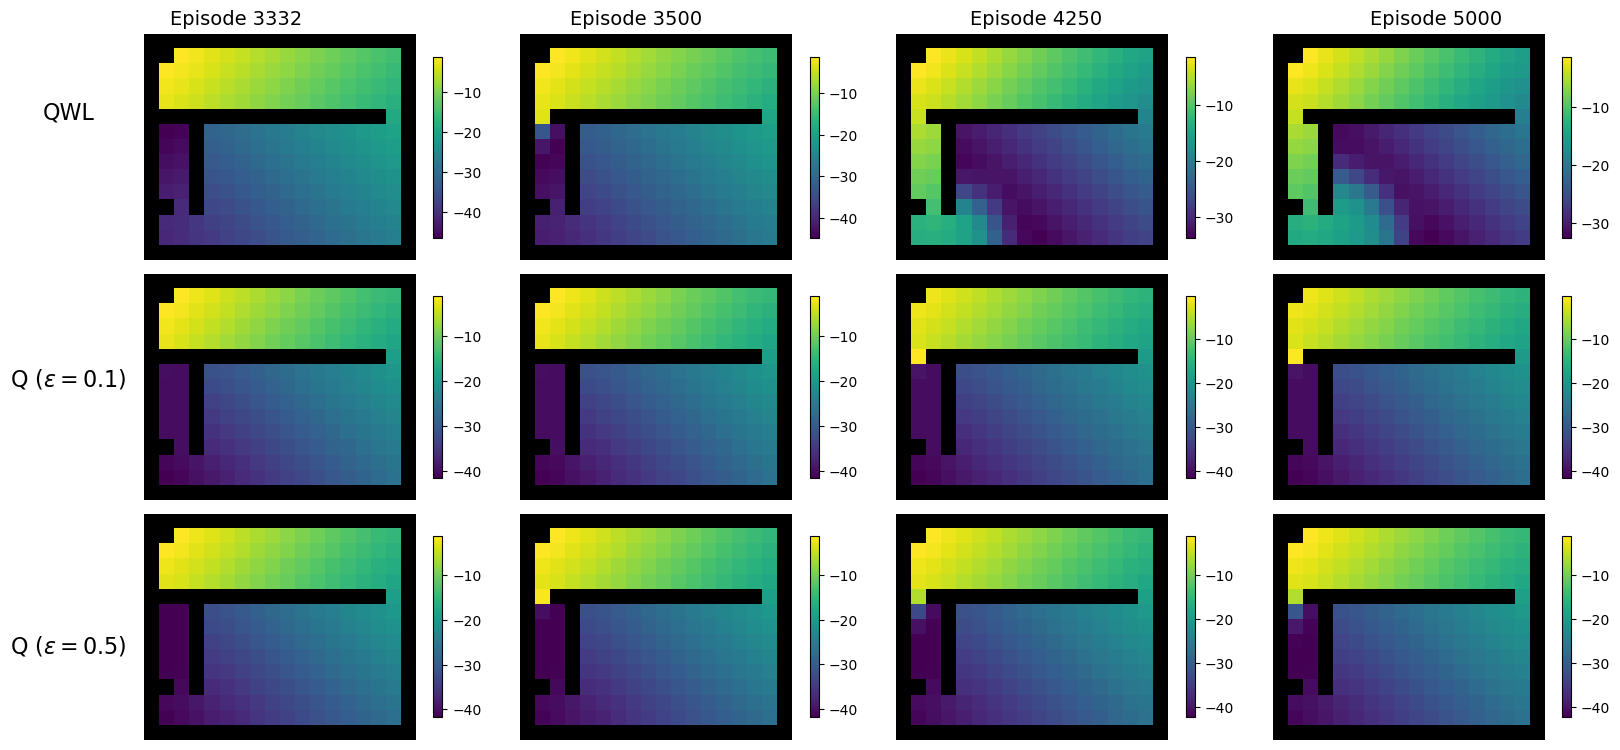

In [18]:
ncol = len(eps_checks)

nrows=3

fig, axs = plt.subplots(nrows=nrows,ncols=ncol,figsize=(16, 8))
for row,(agent_name, value_funcs) in enumerate(Q_avgs.items()):
    fig.text(0.02,( 2*(nrows-1-row) +1) / (2*nrows), agent_name, ha='center', va='center', fontsize=16)
    for col,(eps_num, Q_avg) in enumerate(value_funcs.items()):
        # agent = agents[agent_name]
        # agent.epsilon = 0.05
        # done = False
        # observation,info= env.reset()
        # greedy_trajectory=[]
        # while not done:
        #     state = tuple(observation["agent"]["pos"])
        #     if (episode+1) >= n_episodes//open_shorcut_factor:
        #         visite_open[state]+=1
        #     else: 
        #         visited[state]+=1
        #     #action = agent.select_action(state)
        #     action = agent.select_action(state)

        #     observation, reward, done,_, info = env.step(action)
        #     if done:
        #         avg_steps+=info["steps"]
        #     next_state = tuple(observation["agent"]["pos"])
        #     greedy_trajectory.append(next_state)
        #     state = next_state

        Q_avg = Q_avg.copy()
        if row ==0:
            fig.text((2 * col +1) / (2*ncol), 0.95, f"Episode {eps_num}", ha='center', va='center', fontsize=14)
        Q_avg/=experiment_repeats
        mask = Q_avg == 0
        Q_avg[mask] = np.inf
        masked_Q_avg = np.ma.masked_invalid(Q_avg)
        img =axs[row,col].imshow(masked_Q_avg,cmap = cmap)
        #axs[row,col].set_title(f"Episode {eps_num}", fontsize = 12)
        axs[row,col].axis("off")
        fig.colorbar(img, ax=axs[row,col], orientation='vertical', shrink = 0.8)
        # x = np.array([pos[1] for pos in greedy_trajectory])
        # y = np.array([pos[0] for pos in greedy_trajectory])
        # axs[row,col].plot(x,y,"--",linewidth = 5)
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.show()

In [56]:
(3*(1) +1)/9

0.4444444444444444

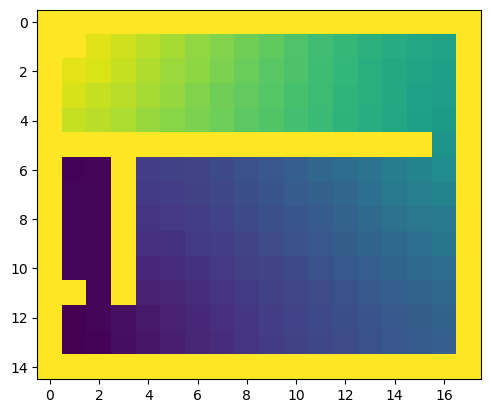

In [13]:
plt.imshow(Q_avgs['Uniform'][3332])